In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from act.qc.qcfilter import QCFilter
from act.plotting import TimeSeriesDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def format_dt_arr(dt_arr: np.ndarray, dt_format="%Y-%m-%d %H:%M:%S") -> np.ndarray:
    """Helper method for printing numpy.datetime64 arrays"""
    dt_df = pd.DataFrame(dt_arr)
    return dt_df.apply(lambda col: col.dt.strftime(dt_format)).values

In [3]:
def parse_datetime(date_str: str) -> np.datetime64:
    """Parses a date or datetime string into a numpy datetime64 object."""
    try:
        return np.datetime64(pd.to_datetime(date_str))
    except ValueError:
        raise ValueError(f"Invalid date format: {date_str}")

def parse_timedelta(time_str: str) -> np.timedelta64:
    """Parses a time duration string into a numpy timedelta64 object."""
    try:
        return np.timedelta64(pd.to_timedelta(time_str))
    except ValueError:
        raise ValueError(f"Invalid time duration format: {time_str}")
    
def to_seconds(timedelta: np.timedelta64) -> float:
    return float(timedelta.astype("timedelta64[ns]") / np.timedelta64(1, "s"))

def to_seconds_vec(timedelta: np.ndarray) -> np.ndarray:
    return timedelta.astype("timedelta64[ns]") / np.timedelta64(1, "s")

def to_timedelta_vec(seconds: np.ndarray) -> np.ndarray:
    return seconds.astype("datetime64[ns]") * np.timedelta64(1, "s")

def to_timedelta(seconds: float) -> np.timedelta64:
    return seconds * np.timedelta64(1, "s")

In [4]:
VARIABLES = [
    "time_bounds",
    "diameter_mobility_bounds",
    "total_N_conc",
    "qc_total_N_conc",
    "aerosol_flow",
    "dN_dlogDp",
    "qc_dN_dlogDp",
]

smps = xr.open_mfdataset("./data/sgpaossmpsE13.b1*.nc").load()
smps = smps[VARIABLES]
smps

<xarray.Dataset> Size: 455kB
Dimensions:                   (time: 288, bound: 2, diameter_mobility: 192)
Coordinates:
  * time                      (time) datetime64[ns] 2kB 2023-06-01 ... 2023-0...
  * diameter_mobility         (diameter_mobility) float32 768B 1.02 ... 982.2
Dimensions without coordinates: bound
Data variables:
    time_bounds               (time, bound) datetime64[ns] 5kB 2023-06-01 ......
    diameter_mobility_bounds  (diameter_mobility, bound) float32 2kB 1.0 ... ...
    total_N_conc              (time) float32 1kB 1.465e+03 ... 1.561e+03
    qc_total_N_conc           (time) int32 1kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    aerosol_flow              (time) float32 1kB 0.993 0.993 ... 0.997 0.996
    dN_dlogDp                 (time, diameter_mobility) float32 221kB nan ......
    qc_dN_dlogDp              (time, diameter_mobility) int32 221kB 1 1 ... 1 1
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.2-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine prod-proc3...

# Bin Averaging

- [DONE] Create output bounds for time and other dimensions
- [DONE] Calculate coordinate / group mappings
- Calculate things for each group
    - Metrics (by variable):
        - [DONE] mean (reported as the bin average)
        - [DONE] std_dev
        - % of bin spanned by indeterminate data
        - % of bin spanned by bad data
    - QC States (mostly by variable):
        - [DONE] 1    QC_BAD:  Transformation could not finish, value set to missing_value.
        - [DONE] 2    QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.
        - [DONE] 32   QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.
        - [DONE] 64   QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.
        - [DONE] 128  QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
        - [DONE] 256  QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.
        - [DONE] 512  QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.
        - [DONE] 1024 QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.
        - [DONE] 2048 QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.
        - [DONE] 4096 QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.
- Wrap up into an output dataset

In [5]:
from typing import Literal


def create_time_bounds(
    start: np.datetime64 | str,
    stop: np.datetime64 | str,
    interval: int | str,
    width: int | float | str | None = None,
    alignment: Literal["left", "right", "center"] | float = "left",
) -> tuple[np.ndarray, np.ndarray]:
    """Creates a 2D array of start and end times between the start and stop times.
    Returns both the 1D coordinate labels and the 2D array of coordinate bounds.


    Args:
        start (np.datetime64 | str): The starting time corresponding with the first
            bound (inclusive). Can be provided either as a numpy datetime64 scalar or as
            a yyyy-mm-dd hh:mm:ss string. Note the first value of the returned bounds
            array may be less than this if the bins are not left-aligned (see alignment
            parameter for more details.)
        stop (np.datetime64 | str): The ending point of the bounds (exclusive). The
            bounds array is guaranteed to end sometime before this point. Can be
            provided either as a numpy datetime64 scalar or as a yyyy-mm-dd hh:mm:ss
            string.
        interval (int | str): The gap between the centers of the output bounds in
            seconds. Can be provided as either a number or as a string (e.g., "30min")
        width (int | str | None, optional): The difference between the end of each bound
            and the start of each bound in seconds. Can be provided as either a number
            or a string (e.g., "30min"). This can be set independently of the interval
            to make the bounds overlap (if the width is greater than the interval),
            introduce gaps (if the width is less than the interval - why, idk), or to
            make the bounds align perfectly (by setting width = interval, the default).
        alignment (float, optional): Controls where the bounds are located relative to
            the label for each bin. Can be provided as a literal string ("left",
            "right", or "center"), or a value from 0.0 - 1.0 to specify an alignment
            in-between the two (left=0, right=1, center=0.5).

    Raises:
        ValueError: Raises an error if the stop time is not greater than the start time.

    Returns:
        np.ndarray: The 1-dimensional array of labels for the bounds.
        np.ndarray: The 2-dimensional array of time bounds.
    """
    if isinstance(start, str):
        start = parse_datetime(start)
    if isinstance(stop, str):
        stop = parse_datetime(stop)
    if start >= stop:
        raise ValueError("Invalid interval: start time must be earlier than stop time.")
    if isinstance(interval, str):
        interval = int(to_seconds(parse_timedelta(interval)))
    if isinstance(width, str):
        width = int(to_seconds(parse_timedelta(width)))
    if isinstance(alignment, str):
        alignment = {"left": 0.0, "right": 1.0, "center": 0.5}[alignment]

    if width is None:
        width = interval

    offset = (alignment) * width

    labels = np.arange(start, stop, to_timedelta(interval)).astype("datetime64[ns]")
    offset = to_timedelta(alignment * width)
    start_values = labels - offset
    end_values = start_values + to_timedelta(width)
    bounds = np.column_stack((start_values, end_values)).astype("datetime64[ns]")

    # np.arange does not properly handle cases where width is a float, and it does not
    # guarantee that the ending bound is open (though it says the ending bound is open
    # in the docs). So we have to manually check for this and remove that point.
    if bounds[-1, -1] > stop:
        bounds = bounds[:-1]
        labels = labels[:-1]

    return labels, bounds

def create_bounds(
    start: float,
    stop: float,
    interval: float,
    width: float | None = None,
    alignment: Literal["left", "right", "center"] | float = "left",
) -> tuple[np.ndarray, np.ndarray]:
    if start >= stop:
        raise ValueError("Invalid interval: start bound must be less than stop bound.")
    if isinstance(alignment, str):
        alignment = {"left": 0.0, "right": 1.0, "center": 0.5}[alignment]
    if width is None:
        width = interval

    labels = np.arange(start, stop, interval)
    offset = alignment * width
    start_values = labels - offset
    end_values = start_values + width
    bounds = np.column_stack((start_values, end_values))

    # np.arange does not properly handle cases where width is a float, and it does not
    # guarantee that the ending bound is open (though it says the ending bound is closed
    # in the docs). So we have to manually check for this and remove that point.
    if bounds[-1, -1] > stop:
        bounds = bounds[:-1]
        labels = labels[:-1]

    return labels, bounds


time_labels, time_bounds = create_time_bounds(
    start="2023-06-01",
    stop="2023-06-01 01:00:00",
    interval="30min",
    alignment="center",
)
height_labels, height_bounds = create_bounds(
    start=0.0,
    stop=1.0,
    interval=0.25,
    alignment="left",
)

print("Labels:")
print(f"\ttime: {format_dt_arr(time_labels).flatten()}")
print(f"\theight: {height_labels}")
print()
print("Bounds:")
print(f"time_bounds:\n{format_dt_arr(time_bounds)}\n")
print(f"height:\n{height_bounds}")

Labels:
	time: ['2023-06-01 00:00:00' '2023-06-01 00:30:00']
	height: [0.   0.25 0.5  0.75]

Bounds:
time_bounds:
[['2023-05-31 23:45:00' '2023-06-01 00:15:00']
 ['2023-06-01 00:15:00' '2023-06-01 00:45:00']]

height:
[[0.   0.25]
 [0.25 0.5 ]
 [0.5  0.75]
 [0.75 1.  ]]


In [6]:
def calculate_time_overlap(input_bin: np.ndarray, output_bin: np.ndarray) -> np.ndarray:
    start = max(input_bin[0], output_bin[0])
    end = min(input_bin[1], output_bin[1])
    overlap = (end - start) / np.timedelta64(1, "s")
    input_duration = (input_bin[1] - input_bin[0]) / np.timedelta64(1, "s")
    return overlap / input_duration if overlap > 0 else 0


input_bin = np.array([np.datetime64('2023-06-01T00:00:00'), np.datetime64('2023-06-01T01:00:00')])
output_bin = np.array([np.datetime64('2023-06-01T00:30:00'), np.datetime64('2023-06-01T01:30:00')])
expected_ratio = (1800 / 3600)  # 1800 seconds overlap / 3600 seconds input bin duration
assert np.isclose(calculate_time_overlap(input_bin, output_bin), expected_ratio), "Test case 1 failed"

# Test case 2: Partial overlap
input_bin = np.array([np.datetime64('2023-06-01T01:00:00'), np.datetime64('2023-06-01T02:00:00')])
output_bin = np.array([np.datetime64('2023-06-01T01:30:00'), np.datetime64('2023-06-01T02:30:00')])
expected_ratio = (1800 / 3600)  # 1800 seconds overlap / 3600 seconds input bin duration
assert np.isclose(calculate_time_overlap(input_bin, output_bin), expected_ratio), "Test case 2 failed"

# Test case 3: No overlap
input_bin = np.array([np.datetime64('2023-06-01T00:00:00'), np.datetime64('2023-06-01T01:00:00')])
output_bin = np.array([np.datetime64('2023-06-01T01:30:00'), np.datetime64('2023-06-01T02:30:00')])
expected_ratio = 0  # No overlap
assert np.isclose(calculate_time_overlap(input_bin, output_bin), expected_ratio), "Test case 3 failed"

# Test case 4: Exact match
input_bin = np.array([np.datetime64('2023-06-01T01:00:00'), np.datetime64('2023-06-01T02:00:00')])
output_bin = np.array([np.datetime64('2023-06-01T01:00:00'), np.datetime64('2023-06-01T02:00:00')])
expected_ratio = 1  # Exact overlap
assert np.isclose(calculate_time_overlap(input_bin, output_bin), expected_ratio), "Test case 4 failed"

In [7]:
# Calculate start and end times for overlapping input and output time bins using broadcasting


# from dataclasses import dataclass


input_bounds = smps.sel(time=slice("2023-06-01 00:21:00", "2023-06-01 01:26:00"))[
    "time_bounds"
].values
output_labels, output_bounds = create_time_bounds(
    start="2023-06-01 01:00:00",
    stop="2023-06-01 1:39:00",
    interval="9min",
    alignment="right",
)
output_labels = format_dt_arr(output_labels).flatten()


def _get_bound_overlaps(
    input_bounds: np.ndarray, output_bounds: np.ndarray
) -> tuple[dict[int, list[int]], dict[int, list[float]], dict[int, list[float]]]:
    # Expand input shape to be (len(inputs), 1)
    input_starts = np.expand_dims(input_bounds[:, 0], axis=-1)
    input_ends = np.expand_dims(input_bounds[:, 1], axis=-1)

    output_starts = output_bounds[:, 0]
    output_ends = output_bounds[:, 1]  # shape is len(output bins)

    input_centers = np.mean(input_bounds, axis=1)
    input_centers_expanded = np.expand_dims(input_centers, axis=1)
    output_centers = np.mean(output_bounds, axis=1)

    # negative means the input is to the left (less than) the output bin center
    # positive means the input is to the right (greater than) the output bin center
    distances = input_centers_expanded - output_centers


    # Calculate the overlaps
    starts = np.maximum(input_starts, output_starts)
    ends = np.minimum(input_ends, output_ends)
    overlaps = np.maximum(0, (ends - starts))

    # Calculate the overlap ratios
    overlap_ratios = overlaps / (input_ends - input_starts)

    # Mask to filter only positive overlaps
    positive_overlap_mask = overlaps > 0

    bin_idxs: dict[int, list[int]] = {}
    bin_overlaps: dict[int, list[float]] = {}
    bin_distances: dict[int, list[float]] = {}

    for j in range(overlap_ratios.shape[1]):
        input_bin_idxs: list[int] = []
        for i in range(overlap_ratios.shape[0]):
            if positive_overlap_mask[i, j]:
                input_bin_idxs.append(i)
        bin_idxs[j] = input_bin_idxs
        bin_overlaps[j] = list(overlap_ratios[input_bin_idxs, j])
        bin_distances[j] = list(distances[input_bin_idxs, j])
    return bin_idxs, bin_overlaps, bin_distances

def get_bound_overlaps(
    input_bounds: np.ndarray, output_bounds: np.ndarray
) -> tuple[dict[int, list[int]], dict[int, list[float]], dict[int, list[float]]]:
    """
    Calculates the overlaps and overlap ratios between input bounds and output bounds.

    Args:
        input_bounds (np.ndarray): An array of shape (n, 2) representing the input bounds,
                                   where each row is [start, end].
        output_bounds (np.ndarray): An array of shape (m, 2) representing the output bounds,
                                    where each row is [start, end].
    
    Returns:
        tuple[dict[int, list[int]], dict[int, list[float]]]: A tuple containing two dictionaries:
            - The first dictionary maps each output bin index to a list of input bin indices 
              that overlap with it.
            - The second dictionary maps each output bin index to a list of distances from
            input values to the output value
    """
    # Convert to numerical arrays to calculate bound overlaps
    if np.issubdtype(input_bounds.dtype, np.datetime64):
        start_time = input_bounds[0, 0]
        input_bounds = to_seconds_vec(input_bounds - start_time)
        output_bounds = to_seconds_vec(output_bounds - start_time)

    bin_idxs, bin_overlaps, bin_distances = _get_bound_overlaps(
        input_bounds=input_bounds,
        output_bounds=output_bounds,
    )
    return bin_idxs, bin_overlaps, bin_distances


bin_idxs, bin_overlaps, bin_distances = get_bound_overlaps(
    input_bounds=input_bounds,
    output_bounds=output_bounds,
)
print(bin_idxs)
print(bin_overlaps)
print(bin_distances)

{0: [5, 6], 1: [7, 8], 2: [8, 9, 10], 3: [10, 11, 12], 4: [12]}
{0: [0.8, 1.0], 1: [1.0, 0.8], 2: [0.2, 1.0, 0.6], 3: [0.4, 1.0, 0.4], 4: [0.6]}
{0: [-180.0, 120.0], 1: [-120.0, 180.0], 2: [-360.0, -60.0, 240.0], 3: [-300.0, 0.0, 300.0], 4: [-240.0]}


In [8]:
def add_empty_transform_qc_var(dataset: xr.Dataset, input_var_name: str) -> str:
    qc_var_name = f"qc_{input_var_name}"
    input_long_name = dataset[input_var_name].attrs.get("long_name", input_var_name)
    dataset[qc_var_name] = xr.full_like(
        dataset[input_var_name], fill_value=0, dtype=np.int64
    )

    dataset[qc_var_name].attrs = dict(
        long_name = f"Quality check results on field: {input_long_name}",
        units = "1",
        flag_masks = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], dtype=np.uint32),
        flag_meanings = [
            "QC_BAD:  Transformation could not finish, value set to missing_value.",
            "QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.",
            "QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.",
            "QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.",
            "QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point.",
            "QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.",
            "QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.",
            "QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.",
            "QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.",
            "QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.",
            "QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.",
            "QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.",
            "QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.",
        ],
        flag_assessments = [
            "Bad",
            "Indeterminate",
            "Indeterminate",
            "Indeterminate",
            "Indeterminate",
            "Indeterminate",
            "Indeterminate",
            "Bad",
            "Bad",
            "Bad",
            "Indeterminate",
            "Bad",
            "Indeterminate",
        ],
        flag_comments = [
            "An example that will trip this bit is if all values are bad or outside range.",
            "",
            "An example of why this may occur is if one or both of the nearest points was flagged as bad.  Applies only to interpolate transformation method.",
            "This occurs because the input grid does not span the output grid, or because all the points within range and on one side of the target were flagged as bad.  Applies only to the interpolate transformation method.",
            "Applies only to subsample transformation method.",
            "Applies only to the bin average transformation method.",
            'The output "average" value is set to zero, independent of the value of the input.  Applies only to bin average transformation method.',
            'Nearest good bracketing points are farther away than the "range" transform parameter if transformation is done using the interpolate or subsample method, or "width" if a bin average transform is applied.  Test can also fail if more than half an input bin is extrapolated beyond the first or last point of the input grid.',
            "The transformation could not be completed. Values in the output grid are set to missing_value and the QC_BAD bit is also set.",
            "Applies only to the bin average transformation method.",
            "Applies only to the bin average transformation method.",
            "Applies only to the bin average transformation method.",
            "Applies only to the bin average transformation method.",
        ],
        standard_name = "quality_flag",
    )
    return qc_var_name

def add_empty_std_dev_var(dataset: xr.Dataset, input_var_name: str) -> str:
    std_var_name = f"{input_var_name}_std"
    dataset[std_var_name] = xr.full_like(
        dataset[input_var_name], fill_value=np.nan, dtype=np.float64
    )
    dataset[std_var_name].attrs = dict(
        long_name=f"Metric std for field {input_var_name}",
        units=dataset[input_var_name].attrs.get("units", "1")
    )
    return std_var_name

def add_empty_goodfrac_var(dataset: xr.Dataset, input_var_name: str) -> str:
    goodfrac_var_name = f"{input_var_name}_goodfraction"
    dataset[goodfrac_var_name] = xr.full_like(
        dataset[input_var_name], fill_value=np.nan, dtype=np.float64,
    )
    dataset[goodfrac_var_name].attrs = dict(
        long_name=f"Metric goodfraction for field {input_var_name}",
        units="1"
    )
    return goodfrac_var_name

In [9]:
def is_qc_var(data_array: xr.DataArray) -> bool:
    starts_with_qc = str(data_array.name).startswith("qc_")
    has_qc_standard_name = str(data_array.attrs.get("standard_name", "")) == "quality_flag"
    return starts_with_qc or has_qc_standard_name

def is_std_dev_var(data_array: xr.DataArray) -> bool:
    ends_with_goodfrac = str(data_array.name).endswith("_std")
    has_metric_long_name = str(data_array.attrs.get("long_name", "")).startswith("Metric std for field")
    return ends_with_goodfrac or has_metric_long_name
 
def is_goodfrac_var(data_array: xr.DataArray) -> bool:
    ends_with_goodfrac = str(data_array.name).endswith("_goodfraction")
    has_metric_long_name = str(data_array.attrs.get("long_name", "")).startswith("Metric goodfraction for field")
    return ends_with_goodfrac or has_metric_long_name
    

def is_metric_var(data_array: xr.DataArray) -> bool:
    return is_std_dev_var(data_array) or is_goodfrac_var(data_array)


def empty_dataset_like(input_dataset: xr.Dataset, coord_name: str, coord_values: np.ndarray, coord_bounds: np.ndarray, add_transform_qc: bool = True, add_metric_vars: bool = False) -> xr.Dataset:
    """Creates a new xr.Dataset containing the same variables and metadata as the input
    dataset, but with new coordinate values and bounds for the provided coordinate
    variable.

    Other coordinate variables and coordinate bounds variables will remain untouched.
    All data variables that are at least partially dimensioned by the provided
    coordinate will have their metadata copied but their values will be set to NaN.
    Variables that are dimensioned solely by other coordinate variables will be copied
    directly over.
    
    Args:
        input_dataset (xr.Dataset): The input xarray Dataset.
        coord_name (str): The name of the coordinate variable to modify.
        coord_values (np.ndarray): The new values for the coordinate variable.
        coord_bounds (np.ndarray): The new bounds for the coordinate variable.
    
    Returns:
        xr.Dataset: The new xarray Dataset with modified coordinate values and bounds.
    """
    
    # Create a new empty dataset
    new_dataset = xr.Dataset(attrs=input_dataset.attrs)

    # Add coordinates
    for in_coord_name, in_coord_data_array in input_dataset.coords.items():
        if in_coord_name == coord_name:
            new_dataset[in_coord_name] = xr.DataArray(
                coord_values,
                dims=in_coord_data_array.dims,
                attrs=in_coord_data_array.attrs,
            )
        else:
            new_dataset[in_coord_name] = in_coord_data_array

    # Add bounds variables
    for new_coord_name in new_dataset.coords:
        bounds_name = f"{new_coord_name}_bounds"
        bounds_data_array = input_dataset.get(bounds_name, None)
        if new_coord_name == coord_name:
            new_dataset[bounds_name] = xr.DataArray(
                coord_bounds,
                dims=(new_coord_name, "bound"),
                attrs=bounds_data_array.attrs if bounds_data_array is not None else {}
            )
        elif bounds_data_array is not None:
            new_dataset[bounds_name] = bounds_data_array
            
    # Add data variables
    for var_name, data_array in input_dataset.data_vars.items():
        if var_name in new_dataset:  # skip bounds vars
            continue

        if coord_name in data_array.dims:
            if add_transform_qc and is_qc_var(data_array):
                continue
            if add_metric_vars and is_metric_var(data_array):
                continue 

            new_shape = tuple(new_dataset.sizes[d] for d in data_array.dims)
            new_dataset[var_name] = xr.DataArray(
                np.full(new_shape, fill_value=np.nan),
                dims=data_array.dims, 
                attrs=data_array.attrs
            )
            if add_transform_qc:
                add_empty_transform_qc_var(new_dataset, var_name)

            if add_metric_vars:
                add_empty_std_dev_var(new_dataset, var_name)
                add_empty_goodfrac_var(new_dataset, var_name)
        else:
            new_dataset[var_name] = data_array

    return new_dataset

time_labels, time_bounds = create_time_bounds(
    start="2023-06-01 01:00:00",
    stop="2023-06-01 1:39:00",
    interval="9min",
    alignment="right",
)
empty_dataset_like(smps, "time", time_labels, time_bounds, add_metric_vars=True)


<xarray.Dataset> Size: 33kB
Dimensions:                    (time: 5, diameter_mobility: 192, bound: 2)
Coordinates:
  * time                       (time) datetime64[ns] 40B 2023-06-01T01:00:00 ...
  * diameter_mobility          (diameter_mobility) float32 768B 1.02 ... 982.2
Dimensions without coordinates: bound
Data variables: (12/14)
    time_bounds                (time, bound) datetime64[ns] 80B 2023-06-01T00...
    diameter_mobility_bounds   (diameter_mobility, bound) float32 2kB 1.0 ......
    total_N_conc               (time) float64 40B nan nan nan nan nan
    qc_total_N_conc            (time) int64 40B 0 0 0 0 0
    total_N_conc_std           (time) float64 40B nan nan nan nan nan
    total_N_conc_goodfraction  (time) float64 40B nan nan nan nan nan
    ...                         ...
    aerosol_flow_std           (time) float64 40B nan nan nan nan nan
    aerosol_flow_goodfraction  (time) float64 40B nan nan nan nan nan
    dN_dlogDp                  (time, diameter_mobility) float64 8kB nan ... nan
    qc_dN_dlogDp               (time, diameter_mobility) int64 8kB 0 0 0 ... 0 0
    dN_dlogDp_std              (time, diameter_mobility) float64 8kB nan ... nan
    dN_dlogDp_goodfraction     (time, diameter_mobility) float64 8kB nan ... nan
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.2-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine prod-proc3...

In [10]:
diameter_labels, diameter_bounds = create_bounds(
    start=0,
    stop=1000,
    interval=50,
    alignment="left"
)
empty_dataset_like(smps, "diameter_mobility", diameter_labels, diameter_bounds)

<xarray.Dataset> Size: 103kB
Dimensions:                   (time: 288, diameter_mobility: 20, bound: 2)
Coordinates:
  * time                      (time) datetime64[ns] 2kB 2023-06-01 ... 2023-0...
  * diameter_mobility         (diameter_mobility) int64 160B 0 50 ... 900 950
Dimensions without coordinates: bound
Data variables:
    time_bounds               (time, bound) datetime64[ns] 5kB 2023-06-01 ......
    diameter_mobility_bounds  (diameter_mobility, bound) float64 320B 0.0 ......
    total_N_conc              (time) float32 1kB 1.465e+03 ... 1.561e+03
    qc_total_N_conc           (time) int32 1kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    aerosol_flow              (time) float32 1kB 0.993 0.993 ... 0.997 0.996
    dN_dlogDp                 (time, diameter_mobility) float64 46kB nan ... nan
    qc_dN_dlogDp              (time, diameter_mobility) int64 46kB 0 0 0 ... 0 0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.2-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine prod-proc3...

In [11]:
def get_filtered_data(dataset: xr.Dataset, var_name: str, filter_out: Literal["Bad", "Indeterminate"]) -> tuple[np.ndarray, np.ndarray]:
    data = QCFilter(dataset).get_masked_data(var_name, rm_assessments=[filter_out], return_nan_array=False)  # type: ignore
    return np.ma.filled(data, np.nan), data.mask


In [12]:
# Propagating metrics like std_dev, ind coverage %, bad coverage % through multiple
# transformations is hard and seems like it may vary depending on the order you do the
# transformations in. Doing the bin averaging transformation itself as a series of 1D
# transformations makes a lot of sense, however. Maybe metrics (and QC?) should be
# computed using a separate function?
STD_BAD_MAX = 10
STD_IND_MAX = 5
GOODFRAC_BAD_MIN = 0.05
GOODFRAC_IND_MIN = 0.15

def reshape_weights(
    weights: np.ndarray, data_shape: tuple[int, ...], axis: int
) -> np.ndarray:
    new_weights_shape = np.ones(len(data_shape), dtype=int)
    new_weights_shape[axis] = len(weights)
    adjusted_weights = np.reshape(weights, new_weights_shape)
    return adjusted_weights


def _weighted_average(data: np.ndarray, weights: np.ndarray, axis: int) -> np.ndarray:
    weighted_sum = np.nansum(weights * data, axis=axis)
    sum_of_weights = np.nansum(weights, axis=axis)
    with np.errstate(invalid="ignore", divide="ignore"):
        weighted_avg = np.divide(weighted_sum, sum_of_weights)
        weighted_avg = np.where(sum_of_weights == 0, np.nan, weighted_avg)
    return weighted_avg


def _weighted_std(
    data: np.ndarray, weights: np.ndarray, weighted_avg: np.ndarray, axis: int
):
    sum_of_weights = np.nansum(weights, axis=axis)
    expanded_weighted_avg = np.expand_dims(weighted_avg, axis=axis)
    squared_diff = np.square(data - expanded_weighted_avg)
    weighted_squared_diff_sum = np.nansum(weights * squared_diff, axis=axis)

    with np.errstate(invalid="ignore", divide="ignore"):
        weighted_std = np.sqrt(np.divide(weighted_squared_diff_sum, sum_of_weights))
        weighted_std = np.where(sum_of_weights == 0, np.nan, weighted_std)

    return weighted_std


def get_input_variables_for_transform(
    input_dataset: xr.Dataset, coord_name: str
) -> dict[str, xr.DataArray]:
    input_data_variables = {
        str(var_name): data_array
        for var_name, data_array in input_dataset.data_vars.items()
        if (
            (coord_name in data_array.dims)
            and (var_name != f"{coord_name}_bounds")
            and not is_qc_var(data_array)
            and not is_metric_var(data_array)
            # and not str(var_name).startswith("__qc__")  # in-progress transform qc
            # and not str(var_name).startswith("__std__")  # in-progress metric
            # and not str(var_name).startswith("__goodfrac__")  # in-progress metric
        )
    }
    return input_data_variables


def rename_metric_variables(dataset: xr.Dataset) -> xr.Dataset:
    rename_map: dict[str, str] = {}
    for var_name in dataset.data_vars:
        var_name = str(var_name)
        if var_name.startswith("__qc__"):
            qc_var_name = "qc_" + var_name[len("__qc__"):]
            rename_map.pop(qc_var_name, None)  # prevent new name from conflicting
            rename_map[var_name] = qc_var_name
        elif var_name.startswith("__std__"):
            rename_map[var_name] = var_name[len("__std__"):] + "_std"
        elif var_name.startswith("__goodfrac__"):
            rename_map[var_name] = var_name[len("__goodfrac__"):] + "_goodfraction"
        else:
            rename_map[var_name] = var_name
    dataset = dataset[rename_map.keys()].rename_vars(rename_map)
    return dataset


def perform_bin_average_qc_checks(good_mask: np.ndarray, ind_mask: np.ndarray, bad_mask: np.ndarray, weights: np.ndarray, std_dev: np.ndarray, axis: int)-> np.ndarray:
    # X 1       "QC_BAD:  Transformation could not finish, value set to missing_value.",
    # X 2       "QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.",
    #   4       "QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.",
    #   8       "QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.",
    #   16      "QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point.",
    # X 32      "QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.",
    # X 64      "QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.",
    # X 128     "QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.",
    # X 256     "QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.",
    # X 512     "QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.",
    # X 1024    "QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.",
    # X 2048    "QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.",
    # X 4096    "QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.",

    # QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
    if weights.shape[axis] == 0:
        return np.full_like(std_dev, 129, dtype=int)  # also QC_BAD -- bit 1
    
    bad_fraction = bad_mask.mean(axis=axis)
    good_fraction = (~bad_mask).mean(axis=axis)

    # Start performing checks
    result = np.zeros(std_dev.shape, dtype=int)

    # QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate
    result |= 2 * (0 < np.sum(ind_mask, axis=axis))

    # QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.
    result |= 32 * (np.less(0, bad_fraction) & np.less(bad_fraction, 1))

    # QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.
    result |= 64 * (np.nansum(weights, axis=axis) == 0)

    # QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.
    result |= 257 * (np.isclose(bad_fraction, 1.0))  # add 1 for QC_BAD

    # QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.
    # result |= 512 * (0)  # TODO

    # QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.
    # result |= 1024 * (0)  # TODO

    # QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.
    result |= 2048 * (good_fraction < GOODFRAC_BAD_MIN)

    # QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.
    result |= 4096 * (good_fraction < GOODFRAC_IND_MIN)

    # if (result == 98).any():
    #     print("HUH")
    #     print(result)
    #     print(32 * (np.less(0, bad_fraction) & np.less(bad_fraction, 1)))
    #     print(64 * (np.nansum(weights, axis=axis) == 0))
    #     print(257 * (np.isclose(bad_fraction, 1.0)))
    #     print(2048 * (good_fraction < GOODFRAC_BAD_MIN))
    #     print(4096 * (good_fraction < GOODFRAC_IND_MIN))
    #     print("----")

    return result

# TODO: cell_methods attr
# TODO: QC values still not quite matching
def calculate_weighted_averages(
    input_dataset: xr.Dataset,
    coord_name: str,
    coord_labels: np.ndarray,
    coord_bounds: np.ndarray,
    filter_bad_qc: bool = False,
    add_metrics: bool = True,
) -> xr.Dataset:
    """
    Calculates weighted averages for variables based on overlaps between input and output bounds.

    Args:
        input_dataset (xr.Dataset): The input xarray Dataset containing the variables.
        coord_name (str): The name of the coordinate variable to modify.
        coord_labels (np.ndarray): The new values for the coordinate variable.
        coord_bounds (np.ndarray): The new bounds for the coordinate variable.
        filter_bad_qc (bool): Flag to exclude data flagged as Bad from the average.
        add_metrics (bool): Flag to add metrics (std deviation, goodfrac %).

    Returns:
        xr.Dataset: The new xarray Dataset averaged across the new coordinate bounds.
    """
    if filter_bad_qc or add_metrics:
        input_dataset = input_dataset.copy()
        input_dataset.clean.cleanup()  # basically required for act QC functions to work

    input_coord_bounds = input_dataset[f"{coord_name}_bounds"].values

    input_indices, overlap_ratios, _ = get_bound_overlaps(input_coord_bounds, coord_bounds)

    input_data_variables = get_input_variables_for_transform(input_dataset, coord_name)

    output_dataset = empty_dataset_like(
        input_dataset=input_dataset,
        coord_name=coord_name,
        coord_values=coord_labels,
        coord_bounds=coord_bounds,
        add_transform_qc=True,
        add_metric_vars=add_metrics,
    )
    for var_name, data_array in input_data_variables.items():
        axis = data_array.dims.index(coord_name)
        data_values = data_array.values

        _, ind_mask = get_filtered_data(input_dataset, var_name, "Indeterminate")
        filtered_values, bad_mask = get_filtered_data(input_dataset, var_name, "Bad")
        # NOTE: ADI includes indeterminate QC values in what it calls the "good" mask
        good_mask = np.logical_not(bad_mask)

        if filter_bad_qc:
            data_values = filtered_values

        for output_idx, input_idxs in input_indices.items():
            data = data_values.take(input_idxs, axis=axis)
        
            flat_weights = np.array(overlap_ratios[output_idx])
            reshaped_weights = reshape_weights(flat_weights, data.shape, axis)

            # If data is nan, set weight to nan (so that the point doesn't get used).
            weights = np.where(np.isnan(data), np.nan, reshaped_weights)

            avg = _weighted_average(data, weights, axis=axis)
            output_dataset[var_name][{coord_name: output_idx}] = avg

            if add_metrics:
                std = _weighted_std(data, weights, weighted_avg=avg, axis=axis)
                output_dataset[f"{var_name}_std"][{coord_name: output_idx}] = std

                qc = perform_bin_average_qc_checks(
                    good_mask=good_mask.take(input_idxs, axis=axis), 
                    ind_mask=ind_mask.take(input_idxs, axis=axis),
                    bad_mask=bad_mask.take(input_idxs, axis=axis),
                    weights=reshaped_weights,
                    std_dev=std,
                    axis=axis,
                )
                output_dataset[f"qc_{var_name}"][{coord_name: output_idx}] = qc

                # goodfrac = good_mask.take(input_idxs, axis=axis).mean(axis=axis)
                goodfrac = _weighted_average(data=(~bad_mask).take(input_idxs, axis=axis), weights=weights, axis=axis)
                output_dataset[f"{var_name}_goodfraction"][{coord_name: output_idx}] = goodfrac


    return output_dataset


time_labels, time_bounds = create_time_bounds(
    start="2023-06-01 00:00:00",
    stop="2023-06-02 00:00:00",
    interval="60min",
    alignment="center",
)
diameter_labels, diameter_bounds = create_bounds(
    start=0.0,
    stop=1050,
    interval=100,
    alignment="center",
)

time_averaged_ds = calculate_weighted_averages(
    smps,
    "time",
    time_labels,
    time_bounds,
    filter_bad_qc=False,
)
avg_ds = calculate_weighted_averages(
    time_averaged_ds,
    "diameter_mobility",
    diameter_labels,
    diameter_bounds,
    filter_bad_qc=False,
)

diam_averaged_ds = calculate_weighted_averages(
    smps,
    "diameter_mobility",
    diameter_labels,
    diameter_bounds,
    filter_bad_qc=False,
)
# What happens if we do it backwards??
avg_ds2 = calculate_weighted_averages(
    diam_averaged_ds,
    "time",
    time_labels,
    time_bounds,
    filter_bad_qc=False,
)

avg_ds

<xarray.Dataset> Size: 11kB
Dimensions:                    (time: 24, diameter_mobility: 11, bound: 2)
Coordinates:
  * time                       (time) datetime64[ns] 192B 2023-06-01 ... 2023...
  * diameter_mobility          (diameter_mobility) float64 88B 0.0 ... 1e+03
Dimensions without coordinates: bound
Data variables: (12/14)
    time_bounds                (time, bound) datetime64[ns] 384B 2023-05-31T2...
    diameter_mobility_bounds   (diameter_mobility, bound) float64 176B -50.0 ...
    total_N_conc               (time) float64 192B 1.318e+03 ... 2.174e+03
    qc_total_N_conc            (time) int64 192B 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    total_N_conc_std           (time) float64 192B 72.68 78.19 ... 355.3 586.4
    total_N_conc_goodfraction  (time) float64 192B 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ...                         ...
    aerosol_flow_std           (time) float64 192B 0.001106 ... 0.0007592
    aerosol_flow_goodfraction  (time) float64 192B 1.0 1.0 1.0 ... 1.0 1.0 1.0
    dN_dlogDp                  (time, diameter_mobility) float64 2kB 520.8 .....
    qc_dN_dlogDp               (time, diameter_mobility) int64 2kB 34 0 ... 6403
    dN_dlogDp_std              (time, diameter_mobility) float64 2kB 405.8 .....
    dN_dlogDp_goodfraction     (time, diameter_mobility) float64 2kB 1.0 ... nan
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.2-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine prod-proc3...

In [13]:
# adi_bin_avg = xr.open_dataset("./data/bin_average/datastream_output/sgp/sgpmslBinAverageE13.c1/sgpmslBinAverageE13.c1.20230601.000000.cdf")
# adi_bin_avg

# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     ds_adi = xr.open_dataset("/Users/levi260/Downloads/2025-02-07_21:13:38.234891/datastream_output/sgp/sgpmslBinAverageE13.c1/sgpmslBinAverageE13.c1.20230601.000000.cdf")
#     ds_adi.clean.cleanup()

#     for var in ds_adi.data_vars.values():
#         encoding = var.encoding
#         if "missing_value" in encoding:
#             mv = encoding["missing_value"]
#             if isinstance(mv, np.ndarray):
#                 encoding["missing_value"] = mv[0].item()
# ds_adi.to_netcdf("./data/bin_average/datastream_output/sgp/sgpmslBinAverageE13.c1/sgpmslBinAverageE13.c1.20230601.000000.nc")


adi_bin_avg = xr.open_dataset("./data/bin_average/datastream_output/sgp/sgpmslBinAverageE13.c1/sgpmslBinAverageE13.c1.20230601.000000.nc").load()
adi_bin_avg


<xarray.Dataset> Size: 7kB
Dimensions:                       (time: 24, bound: 2, diameter: 11)
Coordinates:
  * time                          (time) datetime64[ns] 192B 2023-06-01 ... 2...
  * diameter                      (diameter) float32 44B 0.0 100.0 ... 1e+03
Dimensions without coordinates: bound
Data variables: (12/27)
    base_time                     datetime64[ns] 8B 2023-06-01
    time_offset                   (time) datetime64[ns] 192B 2023-06-01 ... 2...
    time_bounds                   (time, bound) datetime64[ns] 384B 2023-05-3...
    diameter_bounds               (diameter, bound) float32 88B -50.0 ... 1.0...
    aerosol_count                 (time, diameter) float32 1kB 520.8 ... nan
    qc_aerosol_count              (time, diameter) int32 1kB 32 0 0 ... 289 289
    ...                            ...
    geometric_mean                (time) float32 96B 78.47 74.13 ... 91.22 76.41
    qc_geometric_mean             (time) int32 96B 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    geometric_mean_std            (time) float32 96B 0.4159 3.336 ... 15.19
    geometric_mean_goodfraction   (time) float32 96B 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat                           float32 4B 36.6
    lon                           float32 4B -97.49
Attributes:
    command_line:          data_consolidator -n mslBinAverage -s sgp -f E13 -...
    process_version:       adi-data_consolidator-1.4-0.dev21.dirty.el7
    dod_version:           Not relevant to datasets generated on the fly.
    input_datastreams:     sgpaossmpsE13.b1 : 1.2 : 20230601.000000
    site_id:               sgp
    platform_id:           mslBinAverage
    facility_id:           E13
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpmslBinAverageE13.c1
    history:               created by user lansing on machine dev-proc2.adc.a...

500.0nm


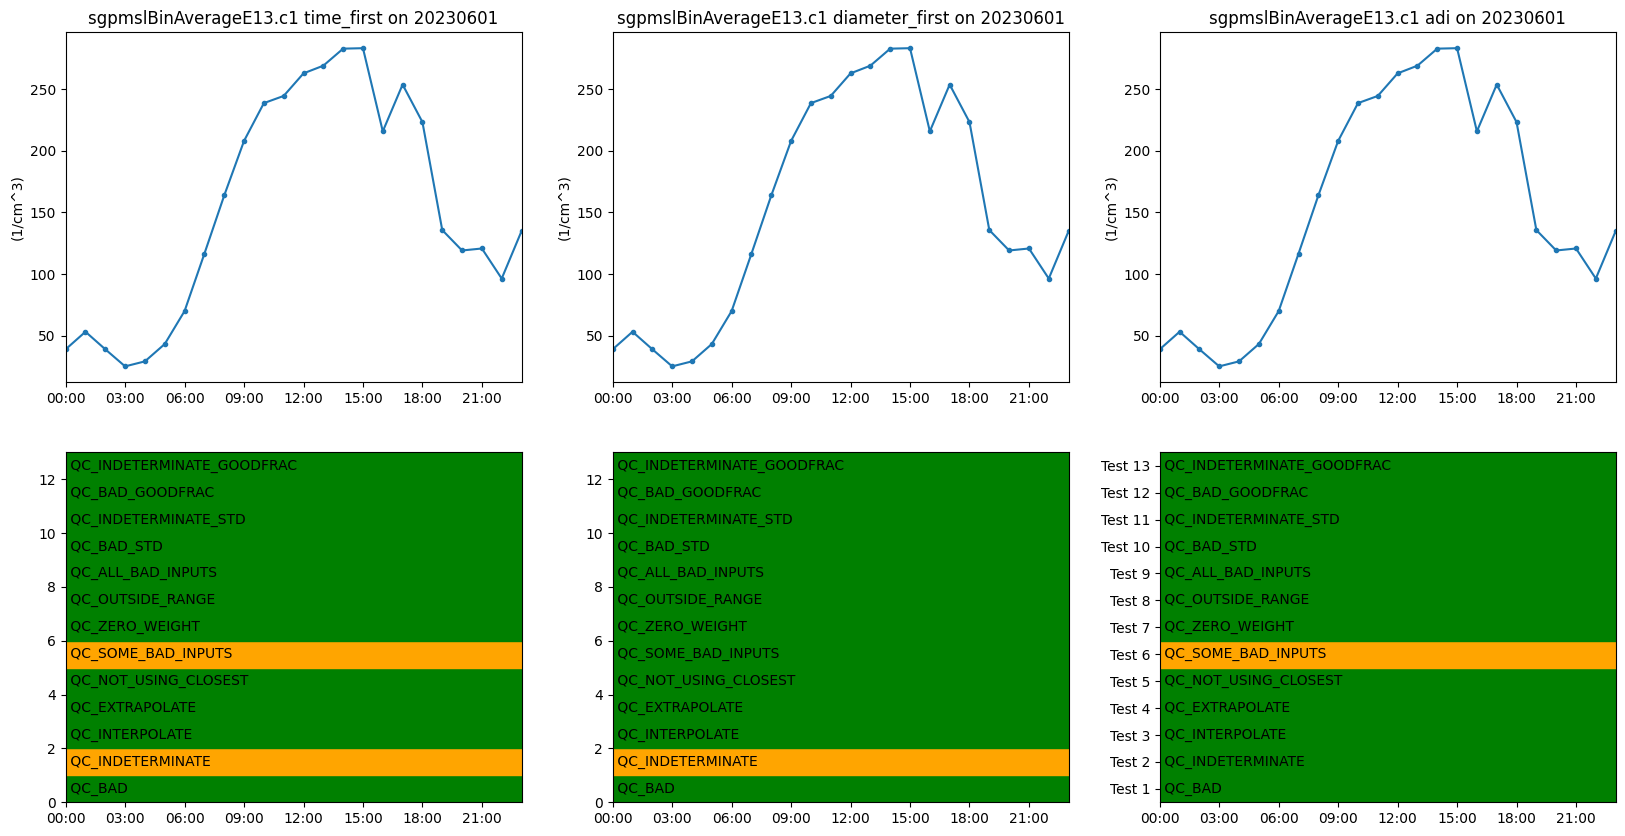

In [14]:
merged = xr.Dataset(data_vars={
    "time_first": avg_ds["dN_dlogDp"],
    "qc_time_first": avg_ds["qc_dN_dlogDp"].astype("int"),
    "diameter_first": avg_ds2["dN_dlogDp"],
    "qc_diameter_first": avg_ds2["qc_dN_dlogDp"].astype("int"),
    "adi": adi_bin_avg["aerosol_count"],
    "qc_adi": adi_bin_avg["qc_aerosol_count"].astype("int"),
},
attrs=adi_bin_avg.attrs)
merged.clean.cleanup()
for _, var in merged.data_vars.items():
    if var.name.startswith("qc_"):
        meanings = var.attrs["flag_meanings"]
        var.attrs["flag_meanings"] = [m.split(":")[0] for m in meanings]

index = 5
merged = merged.isel(diameter_mobility=index, diameter=index)
print(f"{merged.diameter.values}nm")


display = TimeSeriesDisplay(merged, subplot_shape=(2,3), figsize=(20, 10))

display.plot("time_first", subplot_index=(0,0))
display.qc_flag_block_plot("time_first", subplot_index=(1,0))

display.plot("diameter_first", subplot_index=(0,1))
display.qc_flag_block_plot("diameter_first", subplot_index=(1,1))

display.plot("adi", subplot_index=(0,2))
display.qc_flag_block_plot("adi", subplot_index=(1,2))

plt.show()


In [15]:
print(avg_ds["qc_dN_dlogDp"].values[0])
print(avg_ds2["qc_dN_dlogDp"].values[0])
print(adi_bin_avg["qc_aerosol_count"].values[0])

[  34    0    0    0    0   34 6403 6403 6403 6403 6403]
[   2    0    0    0    0    2 6403 6403 6403 6403 6403]
[ 32   0   0   0   0  32 289 289 289 289 289]


In [16]:
var = time_averaged_ds["qc_dN_dlogDp"]  # My output
for i in range(len(var.attrs["flag_meanings"])):
    flag = var.attrs["flag_masks"][i]
    meaning = var.attrs["flag_meanings"][i]
    assess = var.attrs["flag_assessments"][i]
    print(f"{flag}\t {assess[:3]}\t{meaning}")

1	 Bad	QC_BAD:  Transformation could not finish, value set to missing_value.
2	 Ind	QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.
4	 Ind	QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.
8	 Ind	QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.
16	 Ind	QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point.
32	 Ind	QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.
64	 Ind	QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.
128	 Bad	QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
256	 Bad	QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, v

In [17]:
var = adi_bin_avg["qc_aerosol_density"]  # ADI Output
for i in range(len(var.attrs["flag_meanings"])):
    flag = var.attrs["flag_masks"][i]
    meaning = var.attrs["flag_meanings"][i]
    assess = var.attrs["flag_assessments"][i]
    print(f"{flag}\t {assess[:3]}\t{meaning}")

1	 Bad	QC_BAD:  Transformation could not finish, value set to missing_value.
2	 Ind	QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.
4	 Ind	QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.
8	 Ind	QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.
16	 Ind	QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point.
32	 Ind	QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.
64	 Ind	QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.
128	 Bad	QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
256	 Bad	QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, v

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=smps["time"].values, 
    y=smps["aerosol_flow"].values,
    mode='lines',
    name='SMPS',
    marker=dict(color="lightgrey"),
))

fig.add_trace(go.Scatter(
    x=adi_bin_avg["time"].values, 
    y=adi_bin_avg["aerosol_flow"].values,
    error_y=dict(array=adi_bin_avg["aerosol_flow_std"].values),
    mode='lines',
    name='ADI BinAverage',
    marker=dict(color="red"),
))

fig.add_trace(go.Scatter(
    x=avg_ds["time"].values, 
    y=avg_ds["aerosol_flow"].values,
    error_y=dict(array=avg_ds["aerosol_flow_std"].values),
    mode='lines',
    name='BinAverage',
    marker=dict(color="blue"),
))

fig.add_trace(go.Scatter(
    x=avg_ds2["time"].values, 
    y=avg_ds2["aerosol_flow"].values,
    error_y=dict(array=avg_ds2["aerosol_flow_std"].values),
    mode='lines',
    name='BinAverage',
    marker=dict(color="green"),
))

# Update layout
fig.update_layout(
    title='Aerosol Flow over Time',
    xaxis_title='Time',
    yaxis_title='Aerosol Flow'
)

# Show plot
fig.show()

In [19]:
xr.testing.assert_allclose(adi_bin_avg["aerosol_flow"], avg_ds["aerosol_flow"])
xr.testing.assert_allclose(adi_bin_avg["aerosol_flow"], avg_ds2["aerosol_flow"])

In [20]:
avg_ds["diameter_mobility_bounds"].values[2]

smps.sel(diameter_mobility=slice(*avg_ds["diameter_mobility_bounds"].values[2]))

<xarray.Dataset> Size: 43kB
Dimensions:                   (time: 288, bound: 2, diameter_mobility: 14)
Coordinates:
  * time                      (time) datetime64[ns] 2kB 2023-06-01 ... 2023-0...
  * diameter_mobility         (diameter_mobility) float32 56B 151.2 ... 241.4
Dimensions without coordinates: bound
Data variables:
    time_bounds               (time, bound) datetime64[ns] 5kB 2023-06-01 ......
    diameter_mobility_bounds  (diameter_mobility, bound) float32 112B 149.0 ....
    total_N_conc              (time) float32 1kB 1.465e+03 ... 1.561e+03
    qc_total_N_conc           (time) int32 1kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    aerosol_flow              (time) float32 1kB 0.993 0.993 ... 0.997 0.996
    dN_dlogDp                 (time, diameter_mobility) float32 16kB 1.292e+0...
    qc_dN_dlogDp              (time, diameter_mobility) int32 16kB 0 0 0 ... 0 0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.2-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine prod-proc3...

In [21]:
fig = go.Figure()

i = 1  # output dia bin # (0-10) 

filtered_smps = smps.sel(diameter_mobility=slice(*avg_ds["diameter_mobility_bounds"].values[i]))

for d in range(0, len(filtered_smps["diameter_mobility"]), 2):
    dia = filtered_smps.diameter_mobility.values[d]
    fig.add_trace(go.Scatter(
        x=filtered_smps["time"].values, 
        y=filtered_smps["dN_dlogDp"].values[:, d],
        mode='lines',
        name=f'SMPS ({dia:.1f})nm',
        marker_color="lightgrey"
    ))

fig.add_trace(go.Scatter(
    x=adi_bin_avg["time"].values, 
    y=adi_bin_avg["aerosol_count"].values[:, i],
    error_y=dict(array=adi_bin_avg["aerosol_count_std"].values[:, i]),
    mode="lines",
    name="ADI BinAverage",
    marker=dict(color="red"),
))

fig.add_trace(go.Scatter(
    x=avg_ds["time"].values, 
    y=avg_ds["dN_dlogDp"].values[:, i],
    error_y=dict(array=avg_ds["dN_dlogDp_std"].values[:, i]),
    mode='lines',
    name='BinAverage',
    marker=dict(color="blue"),
))

# Update layout
dia_bounds = adi_bin_avg["diameter_bounds"].values[i]
fig.update_layout(
    title=f'Aerosol Count over Time for {int(dia_bounds[0])}-{int(dia_bounds[1])}nm',
    xaxis_title='Time',
    yaxis_title="Aerosol Count (1/cm^3)",
)

# Show plot
fig.show()

In [22]:
fig = go.Figure()

i = 0  # output dia bin # (0-10) 

fig.add_trace(go.Scatter(
    x=adi_bin_avg["time"].values, 
    y=adi_bin_avg["aerosol_count_goodfraction"].values[:, i],
    mode="lines",
    name="ADI BinAverage",
    marker=dict(color="red"),
))

fig.add_trace(go.Scatter(
    x=avg_ds["time"].values, 
    y=avg_ds["dN_dlogDp_goodfraction"].values[:, i],
    mode='lines',
    name='BinAverage',
    marker=dict(color="blue"),
))
fig.add_trace(go.Scatter(
    x=avg_ds2["time"].values, 
    y=avg_ds2["dN_dlogDp_goodfraction"].values[:, i],
    mode='lines',
    name='BinAverage (reversed)',
    marker=dict(color="green"),
))

# Update layout
dia_bounds = adi_bin_avg["diameter_bounds"].values[i]
fig.update_layout(
    title=f'Goodfraction Metric for Aerosol Count over Time for {int(dia_bounds[0])}-{int(dia_bounds[1])}nm',
    xaxis_title='Time',
    yaxis_title="Goodfraction",
)

# Show plot
fig.show()

In [23]:
smps["qc_dN_dlogDp"][0][:109].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [24]:
# Good frac disagrees significantly between the three methods
smps_copy = smps.copy()
smps_copy.clean.cleanup()


time_indices, time_overlap_ratios, _ = get_bound_overlaps(smps_copy["time_bounds"].values, time_bounds)
dia_indices, dia_overlap_ratios, _ = get_bound_overlaps(smps_copy["diameter_mobility_bounds"].values, diameter_bounds)

filtered_values, bad_mask = get_filtered_data(smps_copy, "dN_dlogDp", "Bad")
_, ind_mask = get_filtered_data(smps_copy, "dN_dlogDp", "Indeterminate")
good_mask = np.logical_not(bad_mask)

where_bin_0 = (np.array(time_indices[0]), np.array(dia_indices[0]))
print((np.min(time_indices[0]), np.max(time_indices[0])))
print((np.min(dia_indices[0]), np.max(dia_indices[0])))

good_mask[:6, :109].mean()

(0, 5)
(0, 108)


0.4036697247706422

In [25]:
bad_mask[0, :109]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# Interpolation

- [DONE] Create output bounds for time and other dimensions (same as bin average)
- [DONE] Calculate coordinate / group mappings (same as bin average, just use different term)
- Calculate things for each group
    - Metrics (by variable):
        - [] output (reported as the interp)
    - QC States (mostly by variable):
        - [] 1      (BAD) QC_BAD:  Transformation could not finish, value set to missing_value.
        - [] 2      (IND) QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.
        - [] 4      (IND) QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.
        - [] 8      (IND) QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.
        <!-- - [] 16     (IND) QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point. -->
        <!-- - [] 32     (IND) QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform. -->
        <!-- - [] 64     (IND) QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero. -->
        - [] 128    (BAD) QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
        - [] 256    (BAD) QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.
        <!-- - [] 512    (BAD) QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max. -->
        <!-- - [] 1024   (IND) QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max. -->
        <!-- - [] 2048   (BAD) QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min. -->
        <!-- - [] 4096   (IND) QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min. -->
- Wrap up into an output dataset


Questions
- Is the 'range' transformation parameter used to create the bounds variables in the transformed dataset? If not, then
how are the bounds created / what do they mean?

In [26]:
# OUTPUTS
adi_interp = xr.open_dataset("./data/interpolate/datastream_output/sgp/sgpmslInterpolateE13.c1/sgpmslInterpolateE13.c1.20230601.000000.cdf").load()
adi_interp

<xarray.Dataset> Size: 5MB
Dimensions:            (time: 2880, bound: 2, diameter: 201)
Coordinates:
  * time               (time) datetime64[ns] 23kB 2023-06-01 ... 2023-06-01T2...
  * diameter           (diameter) float32 804B 0.0 5.0 10.0 ... 995.0 1e+03
Dimensions without coordinates: bound
Data variables: (12/17)
    base_time          datetime64[ns] 8B 2023-06-01
    time_offset        (time) datetime64[ns] 23kB 2023-06-01 ... 2023-06-01T2...
    time_bounds        (time, bound) datetime64[ns] 46kB 2023-05-31T23:59:45 ...
    diameter_bounds    (diameter, bound) float32 2kB -2.5 2.5 ... 1.002e+03
    aerosol_flow       (time) float32 12kB 0.993 0.993 0.993 ... 0.9957 0.9956
    qc_aerosol_flow    (time) int32 12kB 8 8 8 8 8 0 0 0 0 ... 0 0 0 0 0 8 8 8 8
    ...                 ...
    geometric_mean     (time) float32 12kB 78.74 78.74 78.74 ... 102.5 103.9
    qc_geometric_mean  (time) int32 12kB 8 8 8 8 8 0 0 0 0 ... 0 0 0 0 0 8 8 8 8
    lat                float32 4B 36.6
    lon                float32 4B -97.49
    total_N_conc       (time) float32 12kB 1.531e+03 1.518e+03 ... 1.525e+03
    qc_total_N_conc    (time) int32 12kB 8 8 8 8 8 0 0 0 0 ... 0 0 0 0 0 8 8 8 8
Attributes:
    command_line:          data_consolidator -n mslInterpolate -s sgp -f E13 ...
    process_version:       adi-data_consolidator-1.4-0.dev21.dirty.el7
    dod_version:           Not relevant to datasets generated on the fly.
    input_datastreams:     sgpaossmpsE13.b1 : 1.2 : 20230601.000000
    site_id:               sgp
    platform_id:           mslInterpolate
    facility_id:           E13
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpmslInterpolateE13.c1
    history:               created by user lansing on machine dev-proc2.adc.a...

In [27]:
time_labels, time_bounds = create_time_bounds(
    start="2023-06-01 00:00:00",
    stop="2023-06-02 00:00:00",
    interval="30s",
    alignment="center",
)

print((time_labels == adi_interp["time"].values).all())
print((time_bounds == adi_interp["time_bounds"].values).all())

time_bounds

True
True


array([['2023-05-31T23:59:45.000000000', '2023-06-01T00:00:15.000000000'],
       ['2023-06-01T00:00:15.000000000', '2023-06-01T00:00:45.000000000'],
       ['2023-06-01T00:00:45.000000000', '2023-06-01T00:01:15.000000000'],
       ...,
       ['2023-06-01T23:58:15.000000000', '2023-06-01T23:58:45.000000000'],
       ['2023-06-01T23:58:45.000000000', '2023-06-01T23:59:15.000000000'],
       ['2023-06-01T23:59:15.000000000', '2023-06-01T23:59:45.000000000']],
      dtype='datetime64[ns]')

In [28]:
def interpolate_single_point(x1_bounds, x2_bounds, y1, y2, target_x):
    """Interpolate a single point given bounds and input values.
    
    Parameters:
    - x1_bounds: Tuple representing the bounds of the first interval (e.g., (x1_start, x1_end)).
    - x2_bounds: Tuple representing the bounds of the second interval (e.g., (x2_start, x2_end)).
    - y1: Y value corresponding to the first interval.
    - y2: Y value corresponding to the second interval.
    - target_x: The target X value where interpolation is to be evaluated.
    
    Returns:
    - Interpolated Y value at the target X value.
    """
    x1_start, x1_end = x1_bounds
    x2_start, x2_end = x2_bounds
    
    # Determine x1 and x2 based on the provided bounds
    x1 = (x1_start + x1_end) / 2
    x2 = (x2_start + x2_end) / 2
    
    # Perform interpolation if target_x is within the bounds
    m = (y2 - y1) / (x2 - x1)

    if x1_start <= target_x <= x2_end:
        interpolated_y = y1 + m * (target_x - x1)
    # Handle extrapolation if target_x is outside the provided ranges
    elif target_x < x1_start:
        interpolated_y = y1 + m * (target_x - x1)
    else: # target_x > x2_end
        interpolated_y = y2 + m * (target_x - x2)
    
    return interpolated_y

interpolate_single_point(
    x1_bounds=[-5, 5],
    x2_bounds=[5, 15],
    y1=0,
    y2=10,
    target_x=5
)

5.0

```python
# Pseudocode for interpolation
def interpolate(
    input_dataset: xr.Dataset,
    coord_name: str,
    coord_labels: np.ndarray,
    coord_bounds: np.ndarray,  # instead of being a bound, this specifies the 'range' to look for nearby points
    filter_bad_qc: bool = True,
    add_metrics: bool = True,
) -> xr.Dataset:
    input_dataset = cleanup(input_dataset)
    input_coord_bounds = input_dataset[f"{coord_name}_bounds"].values

    # This isolates, for each output point, all the input points that are within the
    # range defined by the provided 'coord_bounds'. We also get the overlap ratios, but
    # idk if that is useful
    # TODO: get_bound_distances -- overlaps should be converted to distance from the
    # target point. This will make some of the math a little faster, and also help
    # determine which two points are closest to the target (We later will filter
    # variable-by-variable based on QC, otherwise we'd just return the two closest now).
    index_mapping, bound_distances = get_interp_indices(input_coord_bounds, coord_bounds)

    input_data_variables = get_variables_to_transform(input_dataset, coord_name)

    # Create empty output dataset structure
    output_dataset = ...

    for var_name, data_array in input_data_variables.items():

        # For each variable get a mask for bad data, since for interpolation we don't
        # typically use bad data in the interpolation transform
        filtered_values, bad_mask = get_filtered_data(input_dataset, var_name, "Bad")

        data_values = data_array.values
        if filter_bad_qc:
            data_values = filtered_values

        # Iterate over output points in the specified coordinate dimension.
        # input_idxs is a list of 
        for output_idx, input_idxs in index_mapping.items():
            do_linear_interpolation(data_values, input_idxs, )


```

In [29]:
# for getting the output: input index mappings
output_times, output_time_bounds = create_time_bounds(
    start="2023-06-01 00:00:00",
    stop="2023-06-02 00:00:00",
    interval="30s",
    width="15min",
    alignment="center",
)

idxs, ratios, dists = get_bound_overlaps(input_bounds=smps["time_bounds"].values, output_bounds=output_time_bounds)
idxs[1], ratios[1], dists[1]

([0, 1], [1.0, 0.6], [120.0, 420.0])

In [30]:
# Simple test to make sure interp function works as expected, at least in 1D
print(adi_interp["total_N_conc"].values[1])

nconc = smps["total_N_conc"].values

interpolate_single_point(
    x1_bounds=list(to_seconds_vec(smps["time_bounds"].values[0] - output_times[1])),
    x2_bounds=list(to_seconds_vec(smps["time_bounds"].values[1] - output_times[1])),
    y1=nconc[0],
    y2=nconc[1],
    target_x=0
)

1517.7003


1517.70029296875

In [31]:
output_times, time_range_bounds = create_time_bounds(
    start="2023-06-01 00:00:00",
    stop="2023-06-02 00:00:00",
    interval="30s",
    width="30min",
    alignment="center",
)

idx_mapping, overlap_mapping, distance_mapping = get_bound_overlaps(
    input_bounds=smps["time_bounds"].values,
    output_bounds=time_range_bounds,
)

idx_mapping[10], overlap_mapping[10], distance_mapping[10]

([0, 1, 2, 3], [1.0, 1.0, 1.0, 1.0], [-150.0, 150.0, 450.0, 750.0])

In [32]:
# This seems to work!

idxs_in_input_idx_array = np.argpartition(np.abs(distance_mapping[10]), kth=1)[:2]
np.array(idx_mapping[10])[idxs_in_input_idx_array]

array([0, 1])

In [33]:
smps["time_bounds"].shape

(288, 2)

In [64]:
# Parameters for the eventual function

input_dataset = smps

coord_name = "time"
coord_labels, coord_bounds = create_time_bounds(
    start="2023-06-01 00:00:00",
    stop="2023-06-02 00:00:00",
    interval="30s",
    width="30min",
    alignment="center",
)

var_name = "dN_dlogDp"
data_array = input_dataset[var_name]

filter_bad_qc = True

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
input_coord_bounds = input_dataset[f"{coord_name}_bounds"].values

if np.issubdtype(input_coord_bounds.dtype, np.datetime64):
    start_time = input_coord_bounds[0, 0]
    input_coord_bounds = to_seconds_vec(input_coord_bounds - start_time)
    coord_bounds = to_seconds_vec(coord_bounds - start_time)
    coord_labels = to_seconds_vec(coord_labels - start_time)

# This isolates, for each output point, all the input points that are within the
# range defined by the provided 'coord_bounds'. We also get the overlap ratios, but
# idk if that is useful
# TODO: get_bound_distances -- overlaps should be converted to distance from the
# target point. This will make some of the math a little faster, and also help
# determine which two points are closest to the target (We later will filter
# variable-by-variable based on QC, otherwise we'd just return the two closest now).
index_mapping, _, bound_distances = get_bound_overlaps(input_coord_bounds, coord_bounds)

input_data_variables = get_input_variables_for_transform(input_dataset, coord_name)

# Create empty output dataset structure
output_dataset = empty_dataset_like(
        input_dataset=input_dataset,
        coord_name=coord_name,
        coord_values=coord_labels,
        coord_bounds=coord_bounds,
        add_transform_qc=True,
        add_metric_vars=False,
    )

# for var_name, data_array in input_data_variables.items():

axis = data_array.dims.index(coord_name)

# For each variable get a mask for bad data, since for interpolation we don't
# typically use bad data in the interpolation transform
filtered_values, bad_mask = get_filtered_data(input_dataset, var_name, "Bad")

data_values = data_array.values
if filter_bad_qc:
    data_values = filtered_values

where_not_bad = np.where(~bad_mask)[axis]
# print(where_not_bad)

for (output_idx, input_idxs), (_, distances) in zip(index_mapping.items(), bound_distances.items()):
    # print(output_idx)
    # print(input_idxs)
    # print(distances)

    # TODO: filter input_idxs & distances using the where_not_bad/where_bad array. If it
    # is/isn't in there, keep/remove the point. 

    # now select which 2 points are closest to the output.
    # TODO: make sure inputs have >=2 points
    closest_pts_in_idxs = np.argpartition(np.abs(distances), kth=1)[:2]
    closest_input_idxs = np.array(input_idxs)[closest_pts_in_idxs]
    closest_distances = np.array(distances)[closest_pts_in_idxs]

    # print("closest:")
    # print(closest_pts_in_idxs)
    # print(closest_input_idxs)
    # print(closest_distances)

    # Perform QC Checks
    # - [] 1      (BAD) QC_BAD:  Transformation could not finish, value set to missing_value.
    # - [] 2      (IND) QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.
    # - [] 4      (IND) QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.
    # - [] 8      (IND) QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.
    # - [] 128    (BAD) QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
    # - [] 256    (BAD) QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.

    result = interpolate_single_point(
        x1_bounds=list(input_coord_bounds[closest_input_idxs[0]]),
        x2_bounds=list(input_coord_bounds[closest_input_idxs[1]]),
        y1=data_values[closest_input_idxs[0]],
        y2=data_values[closest_input_idxs[1]],
        target_x=coord_labels[output_idx]
    )

    output_dataset[var_name][{coord_name: output_idx}] = result
    

    # print(f"({result:.3f}, {adi_interp[var_name].values[output_idx]: .3f})")

    # but first, need to update input_idxs and distances to remove points qc'd as bad


In [66]:
result

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        -45.456696,  118.848495,    8.735107,   57.28421 ,   77.

In [78]:
# output_dataset["dN_dlogDp"].coords["diameter_mobility"][172]
print(output_dataset["dN_dlogDp"].values[:5, 172])  # ~500nm
print(adi_interp["dN_dlogDp"].values[:5, 100])  # =500nm

# adi_interp["dN_dlogDp"].coords["diameter"][100]

[30.30550003 29.54780006 28.7901001  28.03240013 27.27470016]
[30.3055 29.5478 28.7901 28.0324 27.2747]


In [42]:
# result = interpolate_single_point(
#     x1_bounds=list(input_coord_bounds[closest_input_idxs[0]]),
#     x2_bounds=list(input_coord_bounds[closest_input_idxs[1]]),
#     y1=data_values[closest_input_idxs[0]],
#     y2=data_values[closest_input_idxs[1]],
#     target_x=coord_bounds[output_idx]
# )

# print(result)
list(input_coord_bounds[closest_input_idxs[0]])
list(input_coord_bounds[closest_input_idxs[1]])
data_values[closest_input_idxs[0]]
data_values[closest_input_idxs[1]]
coord_bounds[output_idx]

array([-900.,  900.])

In [ ]:
# TODO

def perform_interpolation_qc_checks(good_mask: np.ndarray, ind_mask: np.ndarray, bad_mask: np.ndarray, weights: np.ndarray, std_dev: np.ndarray, axis: int)-> np.ndarray:
    # X 1       "QC_BAD:  Transformation could not finish, value set to missing_value.",
    # X 2       "QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate.",
    # X 4       "QC_INTERPOLATE:  Indicates a non-standard interpolation using points other than the two that bracket the target index was applied.",
    # X 8       "QC_EXTRAPOLATE:  Indicates extrapolation is performed out from two points on the same side of the target index.",
    #   16      "QC_NOT_USING_CLOSEST:  Nearest good point is not the nearest actual point.",
    #   32      "QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.",
    #   64      "QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.",
    # X 128     "QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.",
    # X 256     "QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.",
    #   512     "QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.",
    #   1024    "QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.",
    #   2048    "QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.",
    #   4096    "QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.",

    # QC_OUTSIDE_RANGE:  No input samples exist in the transformation region, value set to missing_value.
    if weights.shape[axis] == 0:
        return np.full_like(std_dev, 129, dtype=int)  # also QC_BAD -- bit 1
    
    bad_fraction = bad_mask.mean(axis=axis)
    good_fraction = (~bad_mask).mean(axis=axis)

    # Start performing checks
    result = np.zeros(std_dev.shape, dtype=int)

    # QC_INDETERMINATE:  Some, or all, of the input values used to create this output value had a QC assessment of Indeterminate
    result |= 2 * (0 < np.sum(ind_mask, axis=axis))

    # QC_SOME_BAD_INPUTS:  Some, but not all, of the inputs in the averaging window were flagged as bad and excluded from the transform.
    result |= 32 * (np.less(0, bad_fraction) & np.less(bad_fraction, 1))

    # QC_ZERO_WEIGHT:  The weights for all the input points to be averaged for this output bin were set to zero.
    result |= 64 * (np.nansum(weights, axis=axis) == 0)

    # QC_ALL_BAD_INPUTS:  All the input values in the transformation region are bad, value set to missing_value.
    result |= 257 * (np.isclose(bad_fraction, 1.0))  # add 1 for QC_BAD

    # QC_BAD_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_bad_max.
    # result |= 512 * (0)  # TODO

    # QC_INDETERMINATE_STD:  Standard deviation over averaging interval is greater than limit set by transform parameter std_ind_max.
    # result |= 1024 * (0)  # TODO

    # QC_BAD_GOODFRAC:  Fraction of good and indeterminate points over averaging interval are less than limit set by transform parameter goodfrac_bad_min.
    result |= 2048 * (good_fraction < GOODFRAC_BAD_MIN)

    # QC_INDETERMINATE_GOODFRAC:  Fraction of good and indeterminate points over averaging interval is less than limit set by transform parameter goodfrac_ind_min.
    result |= 4096 * (good_fraction < GOODFRAC_IND_MIN)

    # if (result == 98).any():
    #     print("HUH")
    #     print(result)
    #     print(32 * (np.less(0, bad_fraction) & np.less(bad_fraction, 1)))
    #     print(64 * (np.nansum(weights, axis=axis) == 0))
    #     print(257 * (np.isclose(bad_fraction, 1.0)))
    #     print(2048 * (good_fraction < GOODFRAC_BAD_MIN))
    #     print(4096 * (good_fraction < GOODFRAC_IND_MIN))
    #     print("----")

    return result
